# Consistency of ERA5 data on pressure levels for climate change impact assessments in the aviation sector

Production date: 28-05-2024

Produced by: Sandro Calmanti (ENEA), Alessandro Dell'Aquila (ENEA)

## 🌍 Use case: detecting trends in the large-scale patterns of atmospheric circulation.

## ❓ Quality assessment questions

* **Is ERA5 able to represent consistently the mean vertical structure of zonal wind throughout the entire period 1940-present?**
* **Can I use ERA5 to assess the implications of climate change on inter-continental flight routing?**

Flight trajectories are subject to safety regulations, air space restrictions and other operational constraints, and in general are expected to be sub-optimal in terms of their overall emissions and costs [[1]](https://doi.org/10.1088/1748-9326/abce82). Neverthelees, airlines are looking to optimise flight routes with the dual aim of reducing fuel costs and the $CO_2$ impact of flights [[2]]( https://doi.org/10.3390/aerospace10090744).

Wind data at different pressure levels in the troposphere, ranging between 300hPa and 175hPa, are therfore a key resource for the assessment of the $CO_2$ impact of flight operations and for the optimization of routes [[2]]( https://doi.org/10.3390/aerospace10090744).

This notebook provides an assessment of the long-term consistency of the ERA5 reanalysis in the describing the vertical structure of the zonal wind.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* ERA5 provides a time consistent description of the tropospheric jet-stream and the associated patterns of zonal wind in the lower atmosphere since 1940.
* Sectoral users that need wind data on pressure levels in the troposphere, e.g. for the optimization of flight routes, can use ERA5 safely.
* The zonal circulation in the upper stratosphere shows a significant asymmetric anomaly prior to 1979. Data from the upper stratosphere during the initial years of the reanalysis should be handled carefully.
* etc

```{figure} attachment:6b45bf28-2aca-4d08-9c49-48fa50e801b6.png
---
height: 300px
---
The figure illustrates the zonal mean of the annual temperature in the troposphere (represented by colors) alongside the corresponding isotachs of the zonal wind (lines of equal wind speed). The figure highlights the characteristic jets situated around 200mb, symmetrically positioned near the equator.
```
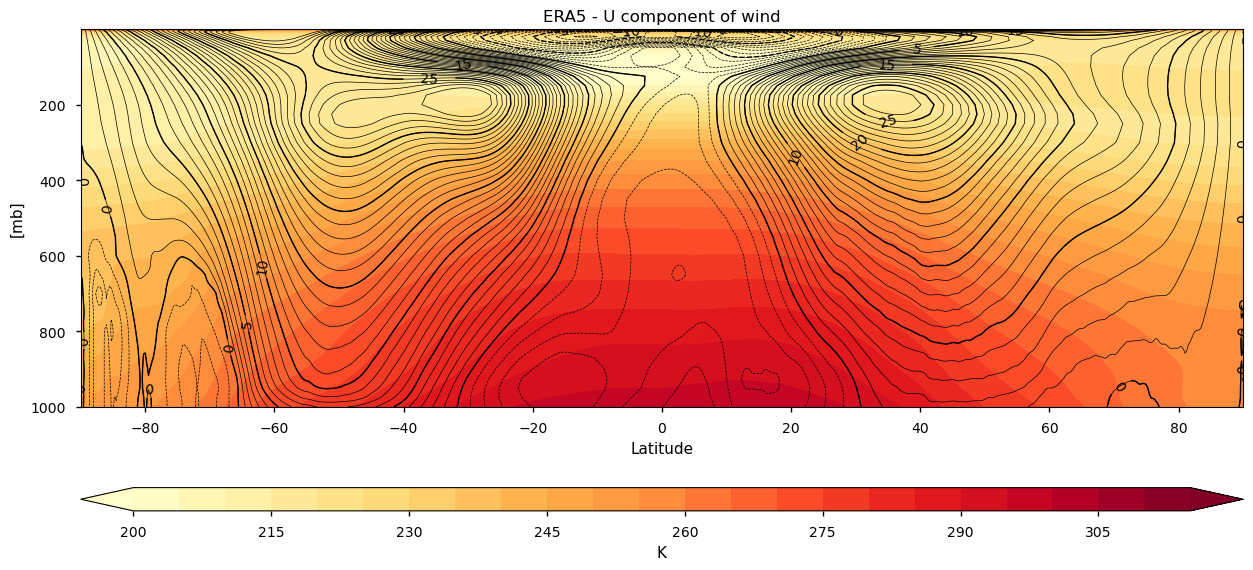

## 📋 Methodology
This notebook aims to assess the zonal wind patterns in ERA5, with a specific focus on two interconnected aspects. Firstly, we conduct a comparison of the vertical structure of the wind profile during the pre-satellite era (i.e., 1940-1978) with the more recent reanalysis period, which benefits from comprehensive satellite observations (1979-2008). Subsequently, we concentrate on the more recent segment of the reanalysis, focusing on the seasonal variability of the tropospheric jet stream's position.

**[](section-1)**
 * Import required packages
 * Define required functions
 * Define data request
   
**[](section-2)**
 * Data retrieval
 * Compute averaged vertical profiles and seasonal anomalies
   
**[](section-3)**
 * Display results
 * Discussion

## 📈 Analysis and results

(section-1)=
### 1. Choose the data to use and setup the code
#### Import required packages
Along with the standard libraries we use the `ScalarFormatter` for a more readable format of the ticks in the vertical axis, `cartopy` to map the position of the jet-stream on a convenient world map and the 
[C3S EQC custom function](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control) `c3s_eqc_automatic_quality_control` to download and manage data.

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from matplotlib.ticker import ScalarFormatter
from c3s_eqc_automatic_quality_control import diagnostics, download, plot
import cartopy.crs as ccrs
plt.style.use("seaborn-v0_8-notebook")

#### Define required functions
The `zonal_mean` and `seasonal_mean` functions are defined to calculate zonally averaged and seasonal data, respectively. The function `mean_over_period`, which splits the zonal mean between pre-satellite (i.e., 1940-1978) and satellite (1979-2008) periods, is also used on the pre-processed data.

In [2]:
def zonal_mean(ds):
    ds = ds.mean("longitude", keep_attrs=True)
    return ds
def seasonal_mean(ds):
    ds = ds.groupby("forecast_reference_time.season").mean("forecast_reference_time", keep_attrs=True)
    return ds
def mean_over_period(
    ds, years_start, years_stop
):
    # Extract periods
    datasets = []
    for year_start, year_stop in zip(years_start, years_stop):
        period = f"{year_start}-{year_stop}"
        ds_masked = ds.where(
            (ds["forecast_reference_time.year"] >= year_start)
            & (ds["forecast_reference_time.year"] <= year_stop),
            drop=True,
        )
        datasets.append(
            ds_masked.mean("forecast_reference_time").expand_dims(period=[period])
        )
    ds_period = xr.merge(datasets)
    return ds_period

#### Define data request
Parameters to be analysed (i.e., time period, pre-satellite and satellite periods, pressure levels) are specified and a `common_request` is defined for the ERA5 product. As the analysis in this notebook focuses on two datasets included in ERA5 (i.e., the temperature and U component of the wind on all pressure levels and the U component of the wind at 200 mb), the `common_request` is updated with a specific request for each dataset (i.e., `request_plev` and `request_200mb`) before downloading.

In [3]:
collection_id = "reanalysis-era5-pressure-levels-monthly-means"
start = "1948-01"
stop = "2008-12" 
# Define pre-satellite and satellite periods of equal length 
years_start = [1940, 1979]
years_stop  = [1978, 2008]#[1978, 2009]

pressure_levels = ["1","2","3","5","7","10","20","30","50","70","100","125","150","175","200","225","250","300","350","400",
                   "450","500","550","600","650","700","750","775","800","825","850","875","900","925","950","975","1000"]
#Define common request
common_request = {
    "format": "grib",
    "product_type": "monthly_averaged_reanalysis",
    "time": "00:00",
    "variable": None,
    "pressure_level": None,
}
#Keys to retrieve T and U on all pressure levels
request_plevs = {
    "variable": ["temperature", "u_component_of_wind"],
    "pressure_level": pressure_levels,
}
#Keys to retrieve U at 200mb
request_200mb = {
    "variable": ["u_component_of_wind"],
    "pressure_level": "200",
}

(section-2)=
### 2. Data retrieval and data analysis
#### Data retrieval
The temperature and U component of the wind on all pressure levels and the U component of the wind at 200 mb are downloaded as two separate arrays and the units of the vertical pressure levels are converted from Pascal (Pa) to hecto-Pascal (hPa), which is equivalent to millibars (mb).

In [4]:
#Retrive data on all pressure levels and compute zonal mean
common_request.update(request_plevs)
request = download.update_request_date(common_request, start=start, stop=stop)
ds_plevs = download.download_and_transform(
    collection_id,
    request,
    transform_func=zonal_mean,
    transform_chunks=True,
    chunks={"year": 1, "time": 1},
)
#Retrive data at 200mb and compute seasonal mean
common_request.update(request_200mb)
request = download.update_request_date(common_request, start=start, stop=stop)
ds_200mb = download.download_and_transform(
    collection_id,
    request,
    transform_func=seasonal_mean,
    transform_chunks=False,
    chunks={"year": 1},
)
#Convert pressure levels to hPa (mb)
ds_plevs["plev"] = ds_plevs["plev"]/100
ds_plevs["plev"].attrs.update({"long_name": "Level", "units": "hPa"})
ds_200mb["plev"] = ds_200mb["plev"]/100
ds_200mb["plev"].attrs.update({"long_name": "Level", "units": "hPa"})

100%|██████████| 61/61 [00:14<00:00,  4.11it/s]


#### Data analysis
The zonally averaged vertical profiles of temperature and zonal wind during the pre-satellite period (1940-1978) and during the more recent satellite era (1979-2008), as well as their difference, are computed. The seasonal anomalies of the U component of the wind at 200mb with respect to the corresponding annual mean are also computed over the entire dataset period. The choice of calculating the seasonal anomalies over the entire dataset period is motivated by that fact that the zonal component of the wind below 100mb shows a consistent behavior between the pre-satellite period and the satellite era (see Discussion).

In [5]:
# Compute the average vertical profiles during the two periods
dsp =  mean_over_period(ds_plevs, years_start, years_stop)
# Compute the difference between the two periods
dsp_diff = dsp.sel(period=dsp["period"].values[0]) - dsp.sel(period=dsp["period"].values[1])
#Compute seasonal anomalies
with xr.set_options(keep_attrs=True):
    ds_anoma = ds_200mb - ds_200mb.mean("season")

(section-3)=
### 3. Plot and describe results
#### Display results
Zonally averaged vertical profiles of temperature and zonal wind calculated over the pre-satellite (i.e., 1940-1978) and satellite (i.e., 1979-2008) periods are shown for comparison, and their difference is also displayed. Maps showing the position of the jet-stream, as described by the seasonal anomaly of the U component of the wind at 200mb with respect to the corresponding annual mean, are also produced.

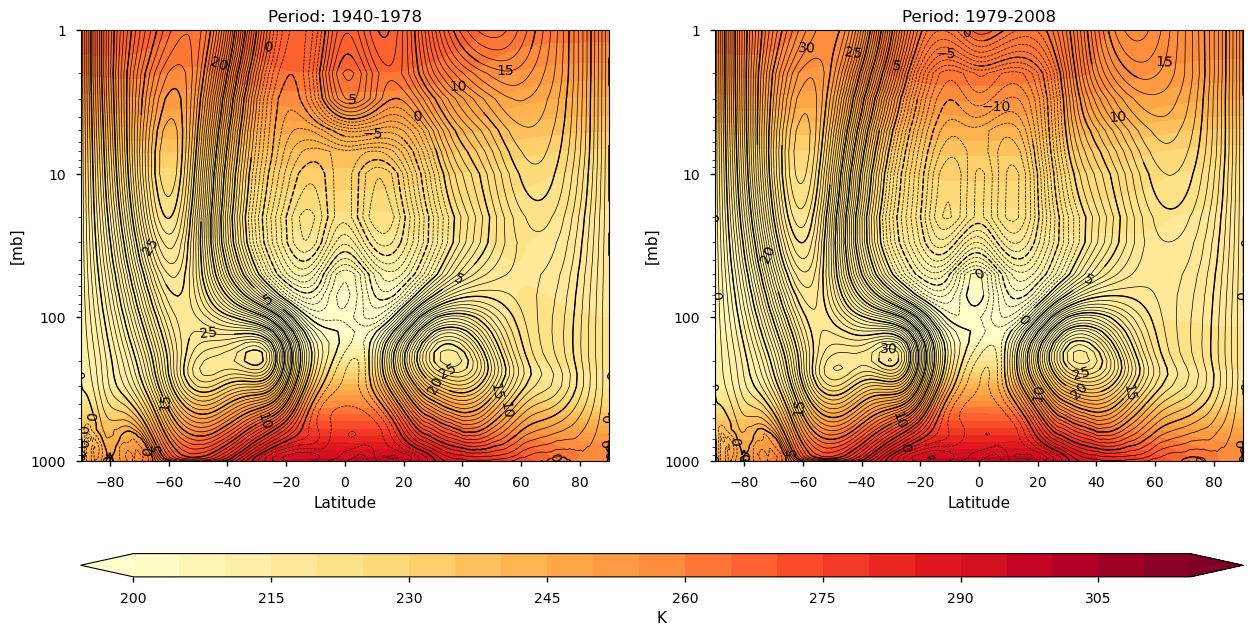

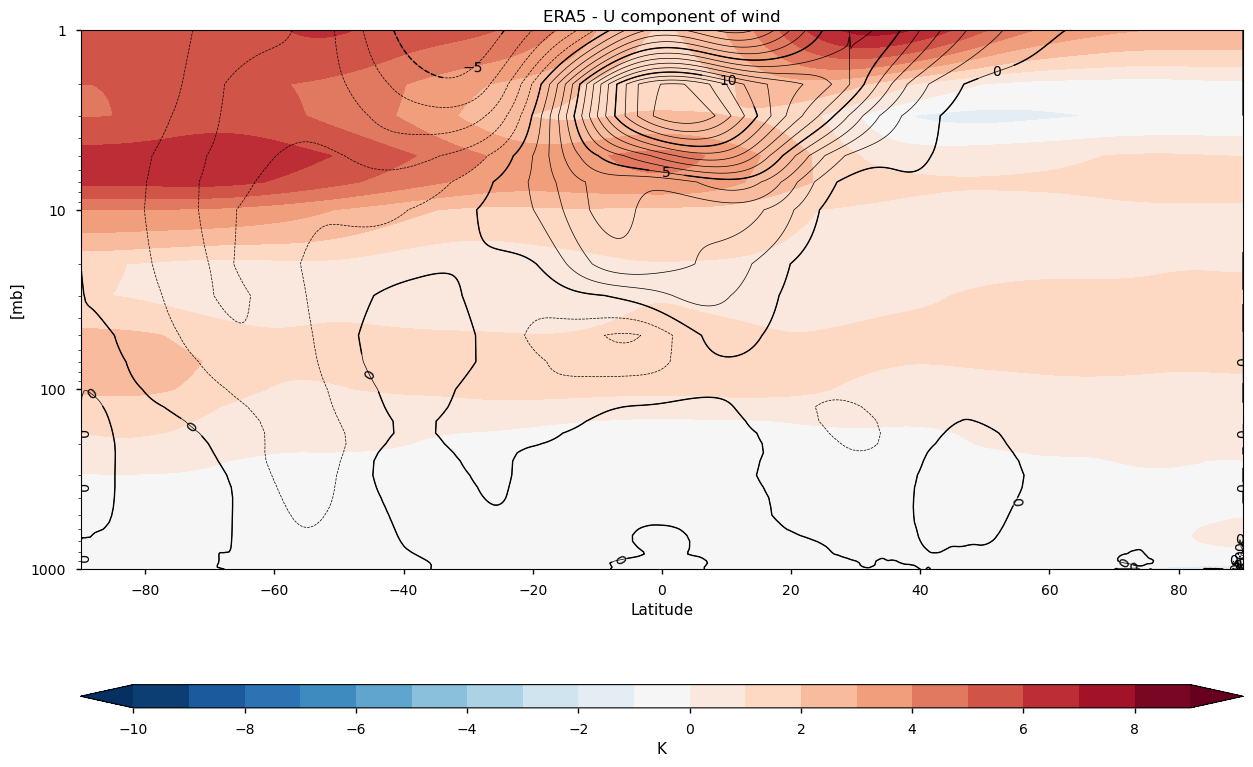

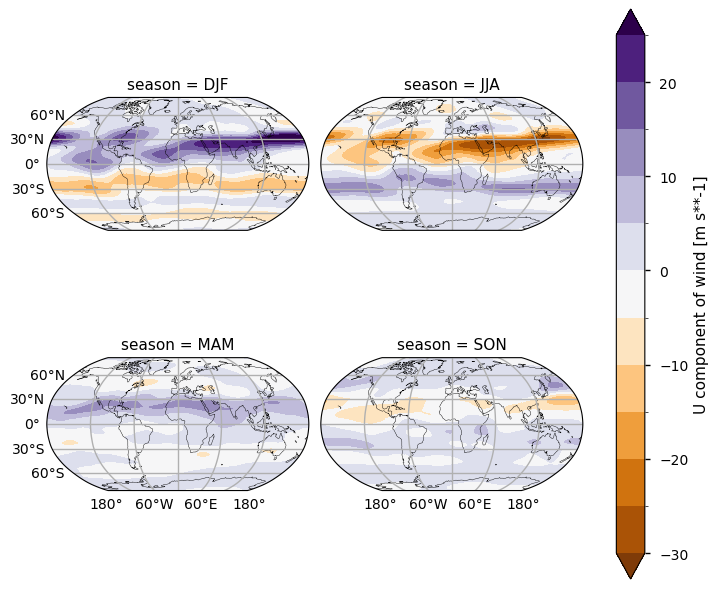

In [17]:
# Plot two periods means
fig, axs=plt.subplots(1,len(dsp["period"]))
for i,ax in enumerate(axs.flat):   
  #Use filled contours for temperature
  cf=ax.contourf(
    dsp["latitude"], dsp["plev"], dsp["t"].sel(period=dsp["period"].values[i]),
    levels=range(200,320,5),
    extend='both',
    cmap="YlOrRd",
  )
  #Use thin contours at intervals of 1 m/s  
  cl1=ax.contour(
    dsp["latitude"], dsp["plev"], dsp["u"].sel(period=dsp["period"].values[i]),
    levels=range(-40,40,1),
    colors='k',
    linewidths=0.5,
  )
  #Use thick countours at intervals of 5 m/s. This contours will be labelled
  cl5=ax.contour(
    dsp["latitude"], dsp["plev"], dsp["u"].sel(period=dsp["period"].values[i]),
    levels=range(-40,40,5),
    colors='k',
    linewidths=1,
  )
  #Labels and others  
  ax.clabel(cl5)
  ax.set_title('Period: ' + dsp["period"].values[i])
  ax.set_yscale("log")
  ax.invert_yaxis()
  ax.set_ylabel('[mb]')
  ax.yaxis.set_major_formatter(ScalarFormatter())
  ax.set_xlabel("Latitude")
fig.colorbar(cf, ax=axs, label="K",  orientation='horizontal', aspect=50)  
fig.set_size_inches(15,8)

# Plot difference
fig, ax=plt.subplots()
#Use filled contours for temperature
cf=ax.contourf(
    dsp_diff["latitude"], dsp_diff["plev"], dsp_diff["t"],
    levels=range(-10,10,1),
    extend='both',
    cmap="RdBu_r",
)
#Use thin contours at intervals of 1 m/s  
cl1=ax.contour(
    dsp_diff["latitude"], dsp_diff["plev"], dsp_diff["u"],
    levels=range(-30,30,1),
    colors='k',
    linewidths=0.5,
)
#Use thick countours at intervals of 5 m/s. This contours will be labelled
cl5=ax.contour(
    dsp_diff["latitude"], dsp_diff["plev"], dsp_diff["u"],
    levels=range(-30,30,5),
    colors='k',
    linewidths=1,
)
#Final settings 
ax.clabel(cl5)
ax.set_title('ERA5 - U component of wind')
ax.set_yscale("log")
ax.invert_yaxis()
ax.set_ylabel('[mb]')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel("Latitude") 
fig.colorbar(cf, ax=ax, label="K",  orientation='horizontal', aspect=50)  
fig.set_size_inches(15,10)

# Seasonal anomaly maps
p1 = plot.projected_map(
    ds_anoma['u'],
    col="season",
    col_wrap=2,
    projection=ccrs.Robinson(), 
    levels=range(-30, 30, 5), 
    cmap="PuOr",
    extend='both',
)

#### Discussion
Comparison between zonally averaged vertical profiles of temperature and zonal wind calculated over the pre-satellite and satellite periods shows that the patterns of both temperature and zonal wind are very similar, with the characteristic positive jets at 200mb, quasi-symmetric around the equator, and a negative jet in the stratosphere, above 100mb. Nonetheless, the period 1940-1978 shows an asymmetric positive jet in the upper stratosphere, which is not present when analysing the 1979-2008 period. The figure showing the anomaly of the period 1940-1978 with respect to 1979-2008, which is considered as a better reference, indicates an high temperature anomaly occurring in the upper stratosphere of the southern hemisphere. The latter is likely related to critical lack of observed data in the higher atmosphere during the pre-satellite period of the reanalysis and triggers a slightly asymmetric positive stratospheric jet during 1940-1979. 

Maps of the position of the jet-stream, as described by the seasonal anomaly of the U component of the wind at 200mb with respect to the corresponding annual mean, show a more intense jet-stream occurring during the winter season (i.e., DJF in the northern hemisphere, JJA in the southern hemisphere) [[3]](https://journals.ametsoc.org/view/journals/clim/17/9/1520-0442_2004_017_1828_svitsh_2.0.co_2.xml?tab_body=pdf) [[4]](https://doi.org/10.1007/s00704-013-0994-x) with a stronger seasonal signal in the northern hemisphere [[5]](https://rmets.onlinelibrary.wiley.com/doi/10.1002/joc.1750).

## ℹ️ If you want to know more
### Key resources
* CDS catalogue entry used in this notebook is the [ERA5 monthly averaged data on pressure levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels-monthly-means?tab=overview)
* Data download is from [CDS](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels-monthly-means?tab=form)
* Product Documentation is available on the [CDS](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels-monthly-means?tab=doc) website  

Code libraries used:
* [C3S EQC custom function](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)

### References

[[1]](https://doi.org/10.1088/1748-9326/abce82) Wells, C. A., Williams, P. D., Nichols, N. K., Kalise, D., & Poll, I. (2021). Reducing transatlantic flight emissions by fuel-optimised routing. Environmental Research Letters, 16(2), 025002.

[[2]](https://doi.org/10.3390/aerospace10090744) Boucher, O., Bellouin, N., Clark, H., Gryspeerdt, E., & Karadayi, J. (2023). Comparison of Actual and Time-Optimized Flight Trajectories in the Context of the In-Service Aircraft for a Global Observing System (IAGOS) Programme. Aerospace, 10(9), 744.

[[3]](https://journals.ametsoc.org/view/journals/clim/17/9/1520-0442_2004_017_1828_svitsh_2.0.co_2.xml?tab_body=pdf) Nakamura, H., & Shimpo, A. (2004). Seasonal variations in the Southern Hemisphere storm tracks and jet streams as revealed in a reanalysis dataset. Journal of Climate, 17(9), 1828-1844.

[[4]](https://doi.org/10.1007/s00704-013-0994-x) Kuang, X., Zhang, Y., Huang, Y., & Huang, D. (2014). Spatial differences in seasonal variation of the upper-tropospheric jet stream in the Northern Hemisphere and its thermal dynamic mechanism. Theoretical and applied climatology, 117, 103-112.

[[5]](https://rmets.onlinelibrary.wiley.com/doi/10.1002/joc.1750) Barton, N. P., & Ellis, A. W. (2009). Variability in wintertime position and strength of the North Pacific jet stream as represented by re‐analysis data. International Journal of Climatology: A Journal of the Royal Meteorological Society, 29(6), 851-862.